In [16]:
import datetime
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import animation, rc

from astropy import time
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import EarthLocation

from lsst.sims.utils import Site

import ephem

In [6]:
def satellite_mean_motion(altitude, mu=const.GM_earth, r_earth=const.R_earth):
    '''
    Compute mean motion of satellite at altitude in Earth's gravitational field.
    
    See https://en.wikipedia.org/wiki/Mean_motion#Formulae
    '''
    no = np.sqrt(4.0 * np.pi ** 2 * (altitude + r_earth) ** 3 / mu).to(u.day)
    return 1 / no

In [2]:
def tle_from_orbital_parameters(
        sat_name, sat_nr, epoch, inclination, raan, mean_anomaly, mean_motion
        ):
    '''
    Generate TLE strings from orbital parameters.
    
    Note: epoch has a very strange format: first two digits are the year, next three
    digits are the day from beginning of year, then fraction of a day is given, e.g.
    20180.25 would be 2020, day 180, 6 hours (UT?)
    '''
    
    # Note: RAAN = right ascention (or longitude) of ascending node
    
    def checksum(line):
        s = 0
        for c in line[:-1]:
            if c.isdigit():
                s += int(c)
            if c == "-":
                s += 1
        return '{:s}{:1d}'.format(line[:-1], s % 10)
    
    tle0 = sat_name
    tle1 = checksum(
        '1 {:05d}U 20001A   {:14.8f}  .00000000  00000-0  50000-4 '
        '0    0X'.format(sat_nr, epoch)
        )
    tle2 = checksum(
        '2 {:05d} {:8.4f} {:8.4f} 0001000   0.0000 {:8.4f} '
        '{:11.8f}    0X'.format(
            sat_nr, inclination.to_value(u.deg), raan.to_value(u.deg),
            mean_anomaly.to_value(u.deg), mean_motion.to_value(1 / u.day)
        ))
    
    return '\n'.join([tle0, tle1, tle2])

In [3]:
altitudes = np.array([550, 1110, 1130, 1275, 1325, 345.6, 340.8, 335.9]) * u.km
inclinations = np.array([53.0, 53.8, 74.0, 81.0, 70.0, 53.0, 48.0, 42.0]) * u.deg
nplanes = np.array([72, 32, 8, 5, 6, 2547, 2478, 2493])
sats_per_plane = np.array([22, 50, 50, 75, 75, 1, 1, 1])

In [4]:
def create_constellation(altitudes, inclinations, nplanes, sats_per_plane):
    
    my_sat_tles = []
    sat_nr = 80000
    for alt, inc, n, s in zip(
            altitudes, inclinations, nplanes, sats_per_plane
            ):
        
        if s == 1:
            # random placement for lower orbits
            mas = np.random.uniform(0, 360, n) * u.deg
            raans = np.random.uniform(0, 360, n) * u.deg
        else:
            mas = np.linspace(0.0, 360.0, s, endpoint=False) * u.deg
            mas += np.random.uniform(0, 360, 1) * u.deg
            raans = np.linspace(0.0, 360.0, n, endpoint=False) * u.deg
            mas, raans = np.meshgrid(mas, raans)
            mas, raans = mas.flatten(), raans.flatten()
        
        mm = satellite_mean_motion(alt)
        for ma, raan in zip(mas, raans):
            my_sat_tles.append(
                # XXX---note magic epoch number here
                tle_from_orbital_parameters(
                    'TEST {:d}'.format(sat_nr), sat_nr, 19050.1,
                    inc, raan, ma, mm
                    ))
            sat_nr += 1
    
    return my_sat_tles

In [7]:
my_sat_tles = create_constellation(altitudes, inclinations, nplanes, sats_per_plane)

In [13]:
ephem_sats = [ephem.readtle(tle.split('\n')[0], tle.split('\n')[1], tle.split('\n')[2]) for tle in my_sat_tles]

In [17]:
telescope = Site(name='LSST')

observer = ephem.Observer()
observer.lat = telescope.latitude_rad
observer.lon = telescope.longitude_rad
observer.elevation = telescope.height

In [25]:
start_time = time.Time(datetime.datetime(2019,11,5,21,0,0,0), 'utc')
# Start, mid, and end of an exposure
td = time.TimeDelta(np.arange(0, 45, 15), format='sec')
times = start_time + td  # 10 min in steps of 1 s

In [26]:
observer.date = ephem.date(times[0].datetime)

In [27]:
observer

<ephem.Observer date='2019/11/5 21:00:00' epoch='2000/1/1 12:00:00' lon='-70:44:57.8' lat='-30:14:39.8' elevation=2650.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

In [28]:
ephem_sats[0].compute(observer)

In [35]:
ephem_sats[0].az,ephem_sats[0].alt, ephem_sats[0].eclipsed

(3.835411787033081, -0.5517210960388184, False)

In [43]:
alts = []
azs = []
eclip = []
for sat in ephem_sats:
    sat.compute(observer)
    alts.append(sat.alt)
    azs.append(sat.az)
    eclip.append(sat.eclipsed)

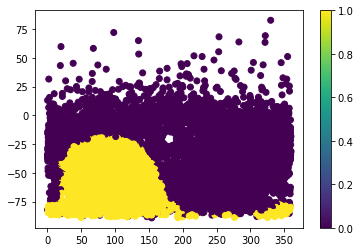

In [45]:
plt.scatter(np.degrees(azs),np.degrees(alts), c=eclip)
plt.colorbar()

True